In [1]:
# Import modues
# -*- encoding: utf-8 -*-
import numpy as np
import matplotlib as mpl
from matplotlib import rc
import math
import pandas as pd
import os
import itertools
import scipy
from scipy import stats
from scipy import ndimage
import seaborn as sns

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

from skimage import measure
from scipy import ndimage
from scipy import misc

from scipy.stats.stats import pearsonr, spearmanr
from collections import  Counter

# from pandas import ExcelWriter
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.stats.api as sm
from sklearn import cross_validation, datasets, linear_model, metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn import cross_validation, datasets, grid_search, linear_model, metrics

from scipy.optimize import curve_fit
from scipy import signal

from sklearn import random_projection
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import KMeans
import pickle
sns.set_style("whitegrid")
sns.set_palette('Accent')

rc('font', family='Arial')  # change font for russian

% matplotlib inline
print 'Import Ready'

Import Ready


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Help function
def grain_to_num(x):
    if x == 'grain':
        return 5000
    elif x == 'rawgrain':
        return 7000
    else:
        return int(x)

markers = ['o','s','d','v','h','>','<','*','^','+']
markers_line = ['-o','-s','-d','-v', '-h', '->','-<', '-*']

cmap = plt.get_cmap('Accent')
colors = [cmap(i) for i in np.linspace(0, 1, 10)][1:]

In [38]:
# Load datasets
spe_df_npks_prep = pd.read_pickle('spe_df_cl_type')  # load smooth spectra

In [39]:
# Drop useless data
spe_df_npks_prep = spe_df_npks_prep.loc[(spe_df_npks_prep.fraction != '100.dry') &
                                       (spe_df_npks_prep.fraction != '500.dry')]

In [40]:
# Class is disbalansed
print Counter(spe_df_npks_prep.fraction)

Counter({'100': 29, '500': 26, 'grain': 24, 'rawgrain': 10})


In [41]:
# Add data to rawgrain class with bootstrap (create 20 false data to rawgrain)
add_rawgrain_prep = spe_df_npks_prep[spe_df_npks_prep['fraction'] == 'rawgrain']

add_rawgrain_prep = add_rawgrain_prep.loc[:, [u'base_s',u'Si', u'P', 
                               u'S', u'Cl', u'K',
                               u'Ca', u'Ti', u'Mn', 
                               u'Fe', u'Sr', u'Mo_Coh', u'Mo']]

mi = add_rawgrain_prep.min(axis=0)
ma = add_rawgrain_prep.max(axis=0)
all_d = []
for j in xrange(len(mi)):
    all_d.append(np.random.randint(mi[j],ma[j],20))
c = add_rawgrain_prep.columns.tolist()
false_rawgrain_prep = pd.DataFrame(np.transpose(np.array(all_d)), columns=c)
false_rawgrain_prep['fraction'] = 'rawgrain'

spe_df_npks_prep = pd.concat([spe_df_npks_prep, false_rawgrain_prep])
print Counter(spe_df_npks_prep.fraction)

Counter({'rawgrain': 30, '100': 29, '500': 26, 'grain': 24})


In [42]:
# Use normalization
fraction_labels = spe_df_npks_prep.fraction
ftype_name = Counter(fraction_labels).keys()
shifr = dict(zip(ftype_name, xrange(len(ftype_name))))
print 'Shifr fraction: ', shifr
fraction_labels = [shifr[x] for x in fraction_labels]
print 'Fraction: ', Counter(fraction_labels)

data_smooth = spe_df_npks_prep[[u'base_s',u'Si', u'P', 
                               u'S', u'Cl', u'K',
                               u'Ca', u'Ti', u'Mn', 
                               u'Fe', u'Sr', u'Mo_Coh', u'Mo']]

data_prep_r = (data_smooth - data_smooth.mean()) / (data_smooth.max() - data_smooth.min())

data_prep_z = (data_smooth - data_smooth.mean()) / data_smooth.std()

Shifr fraction:  {'100': 0, 'rawgrain': 1, 'grain': 2, '500': 3}
Fraction:  Counter({1: 30, 0: 29, 3: 26, 2: 24})


In [43]:
# Check the shape
print data_smooth.shape, data_prep_r.shape, data_prep_z.shape

(109, 13) (109, 13) (109, 13)


In [48]:
def classif_art3(all_data, all_labels, tdata=''):
    # We will evaluate different approaches to classification with the selection of parameters and optimization
    '''
    Function for optimmize classification and calculate main quality metrics.
    Return:
        outputs with data
    Parameters: 
        train_data
        train_labels
        test_data - data for test
        test_labels - labels for test 
        tdata - type of data, if needed
    '''
    
    # Split to train and test
    print Counter(all_labels)
    train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(all_data, all_labels,
                                            test_size=0.2,train_size=0.8,stratify=all_labels)
    print Counter(train_labels)
    print Counter(test_labels)
    # CV startegy and mertics
    # Стратегия кросс-валидации для оценки качества, тут шаффл с 20 % данных для оценки качества
    cv = cross_validation.StratifiedShuffleSplit(train_labels, n_iter = 10, test_size = 0.3, random_state=0)
    cv_metricks = cross_validation.StratifiedShuffleSplit(all_labels, n_iter = 10, test_size = 0.3, random_state=0)
    metrics_all = ['accuracy', 'precision_macro', 'f1_macro', 'recall_macro']
    metriks_names = ['accuracy', 'precision_macro', 'f1_macro', 'recall_macro']
    
    # 1 - Linear classification with gradient descent
    print '\t\tLinesr classif:'
    log_regressor = linear_model.SGDClassifier(penalty='none', shuffle=True, random_state=0)
    # grid search
    parameters_grid = {
        'loss': ['hinge', 'log','squared_loss', 'modified_huber'],
        'fit_intercept': [True, False],
        'max_iter' : np.linspace(1000, 15000, 5, dtype=int),  # итерации
    }
    grid_cv = grid_search.GridSearchCV(log_regressor, parameters_grid, scoring = 'f1_macro', cv = cv)
    grid_cv.fit(train_data, train_labels)
    print 'Best with grid search: '
    print '\testimator: ', grid_cv.best_estimator_
    print '\tscore: ', grid_cv.best_score_
    print '\tparameters: ', grid_cv.best_params_
    print '\tfeatures importamce: '
    a = train_data.columns
    imp = np.mean(np.abs(grid_cv.best_estimator_.coef_),0)
    b = imp / np.sum(imp) * 100.
    importances = pd.DataFrame(zip(a, b))
    importances.columns = ['feature name', 'importance']
    print '\t', importances.sort_values(by='importance', ascending=False)
    
    print "\tDetailed classification report:"
    y_true, y_pred = test_labels, grid_cv.best_estimator_.predict(test_data)
    print '\t', classification_report(y_true, y_pred)
    
    for i in xrange(len(metrics_all)):
        scor = metrics_all[i]
        scoring = cross_validation.cross_val_score(grid_cv.best_estimator_, all_data, all_labels,
                                                     scoring = scor, cv = cv_metricks)
        print 'Best SGDLin ' + metriks_names[i] + ' mean:{}, max:{}, min:{}, std:{}'.format(scoring.mean(), scoring.max(), 
                                                         scoring.min(), scoring.std())
        

    # 2 - RidgeClassifier
    print
    ridge_classifier = linear_model.SGDClassifier(penalty='l2', random_state=0)
    print '\t\tRidge Classifire:'
    # grid search
    parameters_grid = {
        'loss': ['hinge', 'log','squared_loss', 'modified_huber'],
        'fit_intercept': [True, False],
        'max_iter': np.linspace(1000,15000, 5, dtype=int),  
        'alpha': np.linspace(0.0001, 1., num = 10)  # множитель перед регуляризацией
    }
    grid_cv = grid_search.GridSearchCV(ridge_classifier, parameters_grid, scoring = 'f1_macro', cv = cv)
    grid_cv.fit(train_data, train_labels)
    print 'Best with grid search: '
    print '\testimator: ', grid_cv.best_estimator_
    print '\tscore: ', grid_cv.best_score_
    print '\tparameters: ', grid_cv.best_params_
    print '\tfeatures importamce: '
    a = train_data.columns
    imp = np.mean(np.abs(grid_cv.best_estimator_.coef_),0)
    b = imp / np.sum(imp) * 100.
    importances = pd.DataFrame(zip(a, b))
    importances.columns = ['feature name', 'importance']
    print '\t', importances.sort_values(by='importance', ascending=False)
    
    print "\tDetailed classification report:"
    y_true, y_pred = test_labels, grid_cv.best_estimator_.predict(test_data)
    print '\t', classification_report(y_true, y_pred)
    
    for i in xrange(len(metrics_all)):
        scor = metrics_all[i]
        scoring = cross_validation.cross_val_score(grid_cv.best_estimator_, all_data, all_labels,
                                                     scoring = scor, cv = cv_metricks)
        print 'Best Ridge ' + metriks_names[i] + ' mean:{}, max:{}, min:{}, std:{}'.format(scoring.mean(), scoring.max(),
                                                                                           scoring.min(), scoring.std())
    
    
    # 3 - Lasso (L1) linear regression
    print
    print '\t\tLasso Classifire:'
    lasso_classifire = linear_model.SGDClassifier(penalty='l1', random_state=0)
    parameters_grid = {
        'loss': ['hinge', 'log','squared_loss', 'modified_huber'],
        'fit_intercept': [True, False],  # center data
        'max_iter': np.linspace(1000,15000, 5, dtype=int),  
        'alpha': np.linspace(0.0001, 1., num = 10)  # множитель перед регуляризацией
    }
    grid_cv = grid_search.GridSearchCV(lasso_classifire, parameters_grid, scoring = 'f1_macro', cv = cv)
    grid_cv.fit(train_data, train_labels)
    print 'Best with grid search: '
    print '\testimator: ', grid_cv.best_estimator_
    print '\tscore: ', grid_cv.best_score_
    print '\tparameters: ', grid_cv.best_params_
    print '\tfeatures importamce: '
    a = train_data.columns
    imp = np.mean(np.abs(grid_cv.best_estimator_.coef_),0)
    b = imp / np.sum(imp) * 100.
    importances = pd.DataFrame(zip(a, b))
    importances.columns = ['feature name', 'importance']
    print '\t', importances.sort_values(by='importance', ascending=False)
    
    print "\tDetailed classification report:"
    y_true, y_pred = test_labels, grid_cv.best_estimator_.predict(test_data)
    print '\t', classification_report(y_true, y_pred)
    
    for i in xrange(len(metrics_all)):
        scor = metrics_all[i]
        scoring = cross_validation.cross_val_score(grid_cv.best_estimator_, all_data, all_labels,
                                                     scoring = scor, cv = cv_metricks)
        print 'Best L1 ' + metriks_names[i] + ' mean:{}, max:{}, min:{}, std:{}'.format(scoring.mean(), scoring.max(), 
                                                         scoring.min(), scoring.std())
        
    # nonlinear Random Forest
    print
    rf_classifier = RandomForestClassifier(random_state=0)
    print '\t\tRandom Forest:'
    parameters_grid = {
        'n_estimators' : range(2, 100, 20), 
        'max_features' : ['auto', 'sqrt', 'log2', None],  
        'max_depth': [None] + range(2,13,5),  
        'bootstrap' : [False, True],  
        'class_weight': ['balanced', None]  
    }
    grid_cv = grid_search.GridSearchCV(rf_classifier, parameters_grid, scoring = 'f1_macro', cv = cv)
    grid_cv.fit(train_data, train_labels)
    print 'Best with grid search: '
    print '\testimator: ', grid_cv.best_estimator_
    print '\tscore: ', grid_cv.best_score_
    print '\tparameters: ', grid_cv.best_params_
    print '\tfeatures importamce: '
    importances = pd.DataFrame(zip(train_data.columns, grid_cv.best_estimator_.feature_importances_ * 100.))
    importances.columns = ['feature name', 'importance']
    print '\t', importances.sort_values(by='importance', ascending=False)
    print "\tDetailed classification report:"
    y_true, y_pred = test_labels, grid_cv.best_estimator_.predict(test_data)
    print '\t', classification_report(y_true, y_pred)
    
    for i in xrange(len(metrics_all)):
        scor = metrics_all[i]
        scoring = cross_validation.cross_val_score(grid_cv.best_estimator_, all_data, all_labels,
                                                     scoring = scor, cv = cv_metricks)
        print 'Best RF ' + metriks_names[i] + ' mean:{}, max:{}, min:{}, std:{}'.format(scoring.mean(), scoring.max(), 
                                                         scoring.min(), scoring.std())

In [49]:
# Calculate classification for fraction with data
# 
list_df = [data_smooth, data_prep_r, data_prep_z]
list_names=['spe_df_npks_prep', 'data_prep_r', 'data_prep_z']
for i in xrange(len(list_df)):
    name = list_names[i]
    all_df_class = list_df[i]
    print
    print '\t Start new data classification ' + name
    print
    all_df_class.dropna(inplace=True)

    all_df_class = all_df_class.astype(float, inplace=True)
    classif_art3(all_data=all_df_class, all_labels=fraction_labels, tdata='fraction '+name)
    print


	 Start new data classification spe_df_npks_prep

Counter({1: 30, 0: 29, 3: 26, 2: 24})
Counter({1: 24, 0: 23, 3: 21, 2: 19})
Counter({0: 6, 1: 6, 2: 5, 3: 5})
		Linesr classif:


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Best with grid search: 
	estimator:  SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=15000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
	score:  0.707906436529
	parameters:  {'loss': 'log', 'max_iter': 15000, 'fit_intercept': True}
	features importamce: 
	   feature name  importance
5             K   28.187664
2             P   20.938611
6            Ca   20.753671
4            Cl   11.098228
3             S    9.066928
10           Sr    2.968945
0        base_s    2.167351
9            Fe    1.272086
1            Si    1.262065
7            Ti    0.987836
12           Mo    0.669217
8            Mn    0.369684
11       Mo_Coh    0.257713
	Detailed classification report:
	             precision    recall  f1-score   support

          0       0.44      0.67      0.5

Best SGDLin precision_macro mean:0.935109126984, max:1.0, min:0.805555555556, std:0.0599941642898
Best SGDLin f1_macro mean:0.928986131902, max:1.0, min:0.794494720965, std:0.0632562679772
Best SGDLin recall_macro mean:0.927529761905, max:1.0, min:0.787202380952, std:0.0656220004953

		Ridge Classifire:
Best with grid search: 
	estimator:  SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=4500, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
	score:  0.970787545788
	parameters:  {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 4500, 'fit_intercept': True}
	features importamce: 
	   feature name  importance
4            Cl   30.799125
2             P   15.640904
5             K   14.732524
3             S   11.442922
0        base_s    9.579114
6            Ca    6.110882
9  

Best Ridge accuracy mean:0.945454545455, max:1.0, min:0.848484848485, std:0.0402015126104
Best Ridge precision_macro mean:0.953023989899, max:1.0, min:0.8625, std:0.0373364633136
Best Ridge f1_macro mean:0.945767957318, max:1.0, min:0.852479757085, std:0.0388289406955
Best Ridge recall_macro mean:0.943601190476, max:1.0, min:0.84623015873, std:0.0399137917093

		Lasso Classifire:
Best with grid search: 
	estimator:  SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_loss', max_iter=8000,
       n_iter=None, n_jobs=1, penalty='l1', power_t=0.5, random_state=0,
       shuffle=True, tol=None, verbose=0, warm_start=False)
	score:  0.941540824372
	parameters:  {'alpha': 0.0001, 'loss': 'squared_loss', 'max_iter': 8000, 'fit_intercept': False}
	features importamce: 
	   feature name  importance
3             S   24.596737
5             K   18.645693
4            Cl   18.

Process data:  data_norm_r
Labels counter:  Counter({'rawgrain': 30, '100': 29, '500': 26, 'grain': 24})
Index len:  109
After len:  (109, 2)
[0.90861113 0.02974156]
n_cluster =  4
estimator labels:  Counter({3: 44, 1: 30, 0: 29, 2: 6})
[[-0.249, -0.029, u'pressed powder 100 mkm'], [0.573, -0.016, 'granules'], [-0.147, 0.057, 'pressed granules'], [-0.248, -0.002, 'pressed powder 500 mkm']]


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


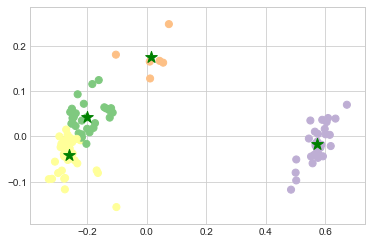

Process data:  data_norm_z
Labels counter:  Counter({'rawgrain': 30, '100': 29, '500': 26, 'grain': 24})
Index len:  109
After len:  (109, 2)
[0.86329941 0.05999724]
n_cluster =  4
estimator labels:  Counter({3: 40, 1: 33, 0: 30, 2: 6})
[[-0.963, -0.113, u'pressed powder 100 mkm'], [2.147, -0.116, 'granules'], [-0.505, 0.278, 'pressed granules'], [-0.937, 0.003, 'pressed powder 500 mkm']]


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


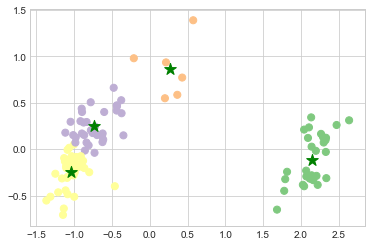

In [52]:
# PCA
names = ['data_norm_r', 'data_norm_z']
datas = [data_prep_r, data_prep_z]
for ind in xrange(len(datas)):
    print 'Process data: ', names[ind]
    X_raw = datas[ind]
    labels = spe_df_npks_prep.fraction
    
    print 'Labels counter: ', Counter(labels)
    x_data = X_raw.loc[:, X_raw.columns!='fraction']
    print 'Index len: ', len(x_data.index)
    feature_names = Counter(labels).keys()

    transformer = RandomizedPCA(n_components=2)
    X_2d = transformer.fit_transform(x_data)
    X_2d_norm = (X_2d - X_2d.mean()) / (X_2d.max() - X_2d.min())
    if ind == 1:
        X_2d_norm = (X_2d - X_2d.mean()) / X_2d.std()
    print 'After len: ', X_2d_norm.shape
    # over 99.9% variance captured by 2d data
    print transformer.explained_variance_ratio_

    # do clustering
    print 'n_cluster = ', len(Counter(labels))
    estimator = KMeans(n_clusters=len(Counter(labels)), init='k-means++', n_init=10)
    estimator.fit(X_2d_norm)

    labels_t = estimator.labels_
    print 'estimator labels: ', Counter(labels_t)
    
    label_color = [colors[l] for l in labels_t]
    
    title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    
    fig, ax = plt.subplots()
    ax.scatter(X_2d_norm[:,0], X_2d_norm[:,1], c=label_color, s=50)
    ax.scatter(estimator.cluster_centers_[:,0], estimator.cluster_centers_[:,1], marker='*', s=150, c='g')
    
    # Calculate all mean for labels
    shifr2 = {
        '100': u'pressed powder 100 mkm',  
        '500': 'pressed powder 500 mkm', 
        'rawgrain': 'granules', 
        'grain': 'pressed granules'
    }
    
    all_means = []
    for f in feature_names:
        x_m = X_2d_norm[labels==f,0].mean()
        y_m = X_2d_norm[labels==f,1].mean()
        all_means.append([round(x_m,3), round(y_m, 3), shifr2[f]])
        
    print all_means
        
    for k in Counter(labels_t).keys():
        x = X_2d_norm[:,0]
        y = X_2d_norm[:,1]
        text_now = ''
                
        plt.text(
            x[labels_t==k].mean(),
            y[labels_t==k].mean(), 
            text_now,
            horizontalalignment='center',
            bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),
        **title_font
        )

    plt.draw()
    plt.savefig(names[ind] + '_RandomizePCA_article3_2.png', dpi=300)
    plt.show()